# Anne Arundel County Executive precinct results map

By [Christine Zhang](mailto:czhang@baltsun.com)

This notebook reads in the raw precinct-level results data from the state Board of Elections [Precinct Results feed](https://elections.maryland.gov/elections/results_data/GG18/PrecinctResults.js) and maps the by-precinct Election Day results for the Anne Arudel County Executive race. For more information about the data, see the [ReadMe file](https://github.com/baltimore-sun-data/maryland-2018-governor-precinct-map/blob/master/readme.md).

**Note:** Precinct-level data include only ballots cast on Election Day, not Early Voting or Absentee/Provisional ballots (see the first point under "Assumptions and Constraints" [here](https://elections.maryland.gov/elections/using_election_data_instructions.html)).

## Import R libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('sf'))

## Read in data

Read in precinct results data and precincts MetaData. The precincts MetaData is a section of the state's [MetaData feed](https://elections.maryland.gov/elections/results_data/GG18/MetaData.js) that provides information on the name and juridictions (in this case, the counties) of each precinct as well as the number of active qualified voters as of the close of registration by party. These files can be found in the `input` folder.

In [2]:
results <- suppressMessages(read_csv('../input/results_raw.csv'))
precincts <- suppressMessages(read_csv('../input/precincts_meta.csv'))

## Clean up precincts MetaData file

Clean up the precincts MetaData file by labeling the active qualified voters with more intuitive column names (i.e., `1` is Republican, `2` Democrat, `3` Libertarian, `4` Green, `5` Unaffiliated and `7` Other parties). See the state's [MetaData feed](https://elections.maryland.gov/elections/results_data/GG18/MetaData.js) for more information. These registration numbers do not include inactive voters (voters whose addresses were not confirmed, for example, but who could have cast a ballot on Election Day). We do not use data on active, qaulified voters in the map, but we provide it in the final output file.

In [3]:
precincts <- precincts %>% select(ID, starts_with('Active'))

precincts$active_qualified_total <- precincts$`ActiveQualified/1` + 
                              precincts$`ActiveQualified/2` + 
                              precincts$`ActiveQualified/3` + 
                              precincts$`ActiveQualified/4` + 
                              precincts$`ActiveQualified/5` + 
                              precincts$`ActiveQualified/7`

precincts <- precincts %>% rename(rep_voters = `ActiveQualified/1`,
                                  dem_voters = `ActiveQualified/2`,
                                  lib_voters = `ActiveQualified/3`,
                                  green_voters = `ActiveQualified/4`,
                                  una_voters = `ActiveQualified/5`,
                                  other_voters = `ActiveQualified/7`) 

## Combine precinct results with precincts MetaData and include only the Anne Arundel County Executive race

In [4]:
results_merge <- merge(results, precincts, by.x = 'precinct_id', by.y = 'ID', all = T)

The `option_id` column in this case represents the candidate names. For this map, we include only Schuh, Pittman and All Write-Ins for the Anne Arundel County Executive race. The `option_id` numbers corrspond to those in the state's [MetaData feed](https://elections.maryland.gov/elections/results_data/GG18/MetaData.js). The filtered results are saved in a dataframe called `aa`.

In [5]:
aa <- results_merge %>% filter(option_id == 13296 | # schuh
                               option_id == 13297 | # pittman
                               option_id == 13298) # write ins 

## For each precinct, calculate each candidate's vote percentage and determine the winner of each precinct

It's easier to do the calculations with the dataframe in ["wide" format](http://www.cookbook-r.com/Manipulating_data/Converting_data_between_wide_and_long_format/). We reshape the `aa` dataframe using the `spread()` function in the `tidyr` package and save the "wide" dataframe as `aa.wide`. Columns are renamed for the candidate whose results they represent. The `winner_margin` column represents the winner's percentage point margin of victory. We do not use this column in the map, but we provide it in the final output file. 

In [6]:
aa <- aa %>% group_by(precinct_id) %>% 
             mutate(total_votes = sum(votes)) # total votes received in the precinct

aa.wide <- aa %>% spread(key = option_id, value = votes) %>% 
                  mutate(schuh = max(`13296`, na.rm = T),
                         pittman = max(`13297`, na.rm = T), 
                         write_in = max(`13298`, na.rm = T)) %>% 
select(-`13296`, -`13297`, -`13298`, -Test, -LastUpdate, -PrecinctResults) %>% distinct()

aa.wide <- aa.wide %>% mutate(perc_schuh = schuh / total_votes * 100, 
                              perc_pittman = pittman / total_votes * 100, 
                              perc_write_in = write_in / total_votes * 100)

aa.wide <- aa.wide %>% group_by(precinct_id) %>% 
                       mutate(perc_winner = max(perc_schuh, perc_pittman, perc_write_in), 
                              winner = case_when(perc_schuh == perc_pittman ~ 'tie',
                                                 perc_winner == perc_schuh ~ 'schuh',
                                                 perc_winner == perc_pittman ~ 'pittman',
                                                 perc_winner == perc_write_in ~ 'write_in',
                                                 perc_winner == 0 | is.na(perc_winner) ~ 'n/a'),
                              winner_margin = case_when(winner == 'schuh' ~ perc_schuh  - perc_pittman,
                                                        winner == 'pittman' ~ perc_pittman - perc_schuh))

**Note:** Dem. Steuart Pittman won 80 precincts to Rep. incumbent Steve Schuh's 115 according to the tally of Election Day votes.

In [7]:
table(aa.wide$winner)


pittman   schuh 
     80     115 

However, Pittman won the County Executive race with 52% of the ***total*** votes (Election Day votes + Early Voting votes + the first canvass of Absentee votes) compared to Schuh's 47.9%. For a breakdown of Election Day versus Early Voting and Absentee/Provisional votes, see the state's results [page](https://elections.maryland.gov/elections/2018/results/General/gen_results_2018_2_by_county_02-1.html). Also see the results for this and other statewide races [here](https://elections2018.news.baltimoresun.com/results/?show=contests/7390.html). 

## Combine results data with precinct shapefiles

Read in Maryland precincts and zip codes shapefiles. The zip codes shapefile is from Maryland's [GIS Data Catalog](http://data.imap.maryland.gov/datasets/maryland-political-boundaries-zip-codes-5-digit). These files can be found in the `shapefiles` folder (they must be unzipped prior to reading in). 

In [8]:
precincts_read <- st_read('../shapefiles/md_all/md_all.shp', quiet = TRUE)

zip_codes <- st_read("../shapefiles/Maryland_Political_Boundaries__ZIP_Codes__5_Digit/Maryland_Political_Boundaries__ZIP_Codes__5_Digit.shp", 
                     quiet = TRUE)

Figure out which zip codes fall in each of the precincts using the `st_intersection()` function in the `sf` package.

In [9]:
intersection <- st_intersection(precincts_read, zip_codes)

intersection <- intersection %>% select(file_id, ZIPCODE1) %>% as.data.frame() 
intersection <- intersection %>% select(-geometry)
intersection <- intersection %>% group_by(file_id) %>% mutate(number = row_number()) %>% 
                arrange(file_id)

# wide format with just one column for zipcodes
intersection.wide <- intersection %>% group_by(file_id) %>%
  summarize_all(paste, collapse=", ") %>% select(-number) %>% rename(zipcode = ZIPCODE1)

although coordinates are longitude/latitude, st_intersection assumes that they are planar
Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”

Combine with `aa.wide`, the Anne Arundel County Executive results dataframe.

In [10]:
merged_aa <- merge(precincts_read %>% filter(JURIS == 'ANNE'), 
                   aa.wide, 
                   by.x = 'ID', 
                   by.y = 'precinct_id', 
                   all = T)

merged_aa <- merge(merged_aa, intersection.wide, by = 'file_id', all.x = T)

There are two precincts that have no results. These are Anne Arundel County's [ghost precincts](https://www.baltimoresun.com/news/maryland/politics/bs-md-ghost-precincts-20181030-story.html) — areas where no voters live.

In [11]:
merged_aa %>% filter(is.na(winner)) %>% select(ID, file_id, NAME, ghost)

ID,file_id,NAME,ghost,geometry
NA,ANNE-001-099,ANNE ARUNDEL PRECINCT 01-099,1,MULTIPOLYGON (((-76.77155 3...
NA,ANNE-004-099,ANNE ARUNDEL PRECINCT 04-099,1,MULTIPOLYGON (((-76.74046 3...


## Create categories for map

Create the following color categories to use as color buckets for the map, according to the percentage of the vote received by teh winning candidate in the precinct:
- `1`: 50% to 55% of the vote
- `2`: 55% to 60%
- `3`: 60% to 65%
- `4`: 65% to 70%
- `5`: 70% to 75%
- `6`: more than 75%

These are saved in the column `perc_cats`.

In [12]:
summary(merged_aa$perc_winner)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  50.05   53.81   59.62   60.74   64.45   89.36       2 

**Note**: In order to color the results on a Blue-Red spectrum, we create a column `perc_cats_map` used only for mapping purposes in which the categories for Dem. Steuart Pittman are multiplied by -1 so that they fall on the left-hand side of the number line. 

In [13]:
merged_aa <- merged_aa %>% mutate(perc_cats = case_when(perc_winner > 50 & perc_winner <= 55 ~ 1, 
                                                        perc_winner > 55 & perc_winner <= 60 ~ 2,
                                                        perc_winner > 60 & perc_winner <= 65 ~ 3,
                                                        perc_winner > 65 & perc_winner <= 70 ~ 4,
                                                        perc_winner > 70 & perc_winner <= 75 ~ 5,
                                                        perc_winner > 75 ~ 6), 
                                  perc_cats_map = ifelse(winner == 'pittman', perc_cats * -1, 
                                                         perc_cats))

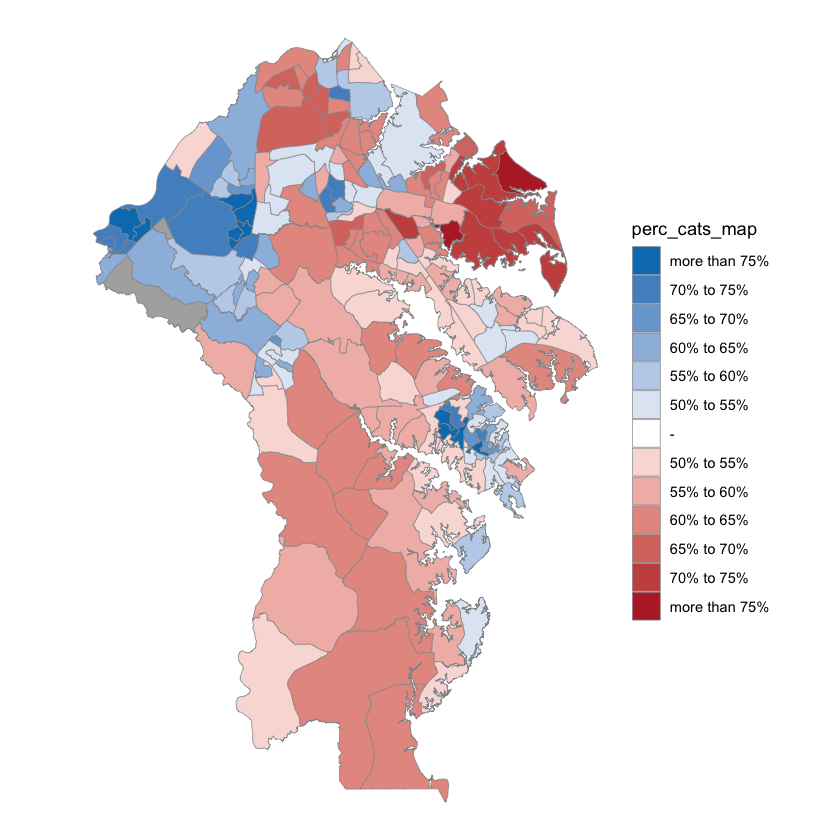

In [14]:
breaks <- seq(-6, 6, 1)

aa.map <- ggplot() + geom_sf(data = merged_aa, aes(fill = perc_cats_map), 
                   color = "#939598", size = 0.2) + 
  scale_fill_gradient2(low = "#007dbe", mid = "white",
                       high = "#b8292f", space = "Lab", midpoint = 0,
                       na.value = "#afafaf", guide = "legend", 
                       aesthetics = "fill", breaks = breaks,
                       labels = c('more than 75%',
                                  '70% to 75%',
                                  '65% to 70%',
                                  '60% to 65%',
                                  '55% to 60%',
                                  '50% to 55%',
                                  '-',
                                  '50% to 55%',
                                  '55% to 60%',
                                  '60% to 65%', 
                                  '65% to 70%',
                                  '70% to 75%',
                                  'more than 75%')) +
  theme_void() +
  theme(panel.grid.major = element_line(colour = 'transparent'))

print(aa.map)

**Note**: The shading does not reflect the vote density (i.e. the votes per square mile) in each precinct.

Label points for the centroids of the following places:
- Linthicum Heights
- Glen Burnie
- Odenton
- Crofton
- Severna Park
- Annapolis
- Edgewater
- Shady Side
- Deale

In [15]:
place = c('Linthicum Heights', 'Glen Burnie', 'Odenton', 'Crofton', 'Severna Park', 'Annapolis', 'Edgewater', 'Shady Side', 'Deale')
lat = c(39.2051, 39.1626, 39.0840, 39.0018, 39.0704, 38.9784, 38.937222, 38.8418, 38.7765)
long = c(-76.6527, -76.6247, -76.7002, -76.6875, -76.5452, -76.4922, -76.558333, -76.5122, -76.5552)

places.df <- data.frame(place, lat, long)

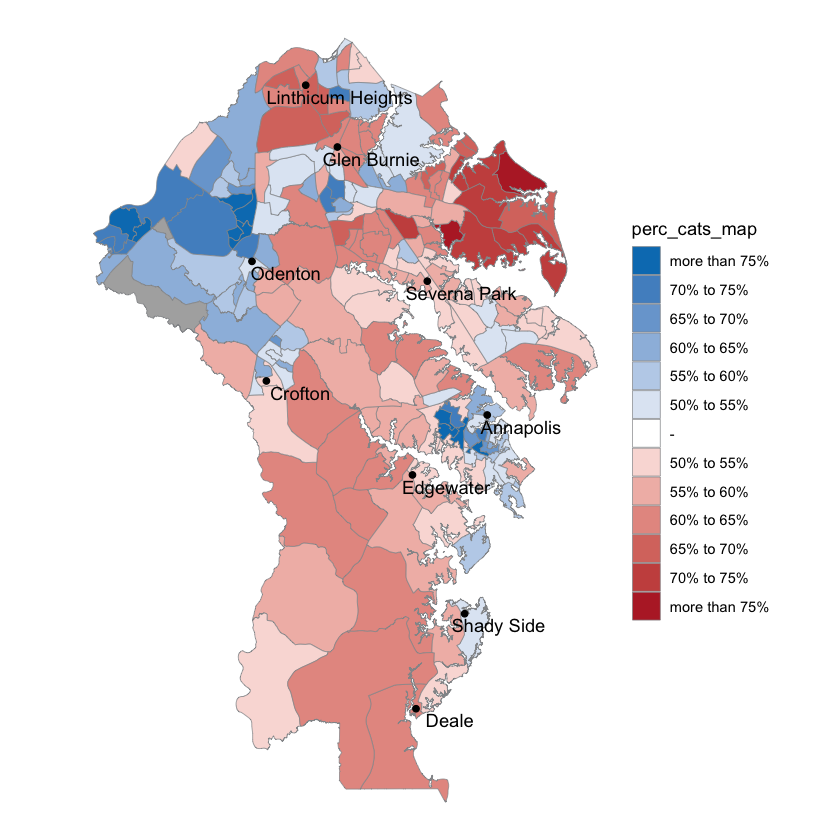

In [16]:
aa.map.places <- aa.map + geom_point(data = places.df, aes(x = long, y = lat)) + 
                          geom_text(data = places.df, 
                                    aes(x = long, y = lat, label = place), 
                                    nudge_x = .03, nudge_y = -.008) 

print(aa.map.places)

## Save processed results data

The processed results can be found in the `output` folder under `results_processed_annearundel_exec.csv`.

In [17]:
merged_aa %>% as.data.frame() %>% select(ID, NAME, county, ghost, rep_voters, dem_voters, lib_voters, green_voters, 
                                         una_voters, other_voters, active_qualified_total, 
                                         schuh, pittman, write_in, total_votes, 
                                         perc_schuh, perc_pittman,
                                         perc_write_in, winner, 
                                         perc_winner, winner_margin, area, zipcode) %>% 
mutate(area_mi = area / 2589988.11033364) %>% # area in square miles 
write_csv('../output/results_processed_annearundel_exec.csv')